In [1]:
%matplotlib inline

from chainer import cuda, Variable, FunctionSet, optimizers
from collections import Counter
import chainer.functions as F
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import pickle

mlp.style.use('fivethirtyeight')

# Deep Lerning - 手書き文字認識

以下の手順で進みます

- データの確認
- Chainerを使ってDeep Learningモデルの作成
- 作成したDeep Learningモデルを使った文字認識実験
- 作成したモデルを保存

参考：[【機械学習】ディープラーニング フレームワークChainerを試しながら解説してみる。](http://qiita.com/kenmatsu4/items/7b8d24d4c5144a686412)

- おまけ: 

参考：

## データの確認

訓練データが50,000件，テストデータが10,000件ある

- 入力 $X$: 28x28の画像を1次元の配列にしたもの
- 出力 $y$: 0~9の数字

In [2]:
mnist = np.load('data/mnist.npz')  # 事前にpre_processing.pyを実行しておくこと

X_train = mnist['X_train'].astype(np.float32)
y_train = mnist['y_train'].astype(np.int32)

X_test = mnist['X_test'].astype(np.float32)
y_test = mnist['y_test'].astype(np.int32)

In [3]:
# 訓練データのサイズ
X_train.shape

(50000, 784)

In [4]:
# テストデータのサイズ
X_test.shape

(10000, 784)

In [5]:
# データの中身はどうなっているのか？
print("Xの中身の例:")
print(X_train[25000][150:200])

print("yの中身の例:")
print(y_train[25000])

Xの中身の例:
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.421875    0.90625     0.53515625  0.12890625  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.        ]
yの中身の例:
3


描かれている数字: 5


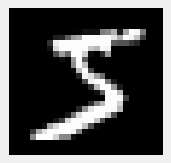

描かれている数字: 7


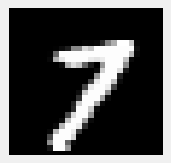

描かれている数字: 8


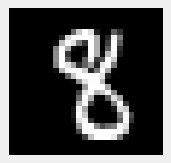

In [7]:
def draw_digit(data):
    size = 28
    X, Y = np.meshgrid(range(size), range(size))
    Z = data.reshape(size, size)
    Z = Z[::-1,:]

    plt.figure(figsize=(2.5, 2.5))
    
    plt.xlim(0, 27)
    plt.ylim(0, 27)
    plt.pcolor(X, Y, Z)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")
    
    plt.show()

# 個々のデータを描画してみる
for i in [0, 40000, 49999]:
    print('描かれている数字: {0}'.format(y_train[i]))
    draw_digit(X_train[i])

## Chainerを使ってDeep Learningモデルの作成

実際にChainerを使ってDeep Learningのモデルを作成してみる

- 活性化関数
- 情報の伝搬処理
- 重みの更新 ( ※時間的な問題で今回説明しません )
- 予測処理

### 活性化関数

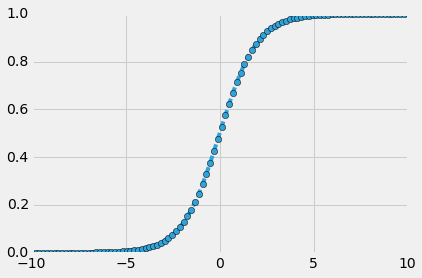

In [8]:
# シグモイド関数を利用する

x_data = np.linspace(-10, 10, 100, dtype=np.float32)
x = Variable(x_data)
y = F.sigmoid(x)

plt.plot(x.data, y.data, 'o--')

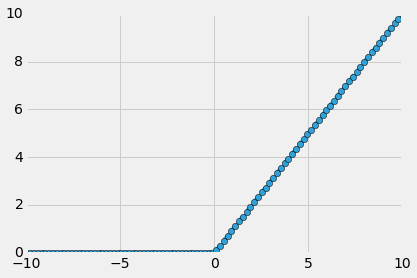

In [9]:
# サンプルだと Rectified Linear Unit function が使われている

x_data = np.linspace(-10, 10, 100, dtype=np.float32)
x = Variable(x_data)
y = F.relu(x)

plt.plot(x.data, y.data, 'o--')

### 情報の伝播処理

In [10]:
def forward(x, train=True):
    h1 = F.dropout(F.sigmoid(model.l1(x)),  train=train)
    h2 = F.dropout(F.sigmoid(model.l2(h1)), train=train)
    return model.l3(h2)

### 重みの更新 ( ※時間的な問題で今回説明しません )

In [11]:
def batch(train_size, batch_size):
    sum_accuracy = 0
    sum_loss     = 0
    
    for i in xrange(0, train_size, batch_size):
        X_batch = X_train[perm[i: i+batch_size]]
        y_batch = y_train[perm[i: i+batch_size]]

        # Chainer用に型変換
        x = Variable(X_batch)
        t = Variable(y_batch)
        
        optimizer.zero_grads()
        y = forward(x)  # 予測結果
        
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t)
        
        loss.backward()
        optimizer.update()

        sum_loss += float(cuda.to_cpu(loss.data)) * batch_size
        sum_accuracy += float(cuda.to_cpu(acc.data)) * batch_size

    return sum_loss, sum_accuracy

### 予測処理

10次元のベクトルの要素のうち，最も値が大きいものを予測値として返す

In [12]:
def predicate(x_data):
    x = np.array([x_data], dtype=np.float32)
    x = Variable(x)
    y = forward(x, train=False)
    return np.argmax(y.data)

## 作成したDeep Learningモデルを使った文字認識実験

作成したDeep Learningのモデルを使って文字認識の実験をしてみましょう

### 学習

- 入力層: 784次元 (28x28の画像データ)
- 出力層: 10次元 (0~9)
- 隠れ層: 324次元 ※値は適当 (18x18)

In [14]:
input_size = 784
output_size = 10
hidden_size = 324

l1_weight = []
l2_weight = []
l3_weight = []

# モデルの定義
model = FunctionSet(l1=F.Linear(input_size, hidden_size),
                    l2=F.Linear(hidden_size, hidden_size),
                    l3=F.Linear(hidden_size, output_size))
optimizer = optimizers.Adam()
optimizer.setup(model.collect_parameters())

バッチ処理を繰り返し行うことによる精度の変化を見ていく

In [15]:
batch_size = 100
n_epoch   = 20
train_size = X_train.shape[0]
test_size = X_test.shape[0]

for epoch in xrange(1, n_epoch+1):
    print('epoch: {0}'.format(epoch))
    perm = np.random.permutation(train_size)

    #####################
    # 学習
    #####################
    
    sum_loss, sum_accuracy = batch(train_size, batch_size)
    print('学習：mean loss={}, accuracy={}'.format(sum_loss / train_size, sum_accuracy / train_size))
    
    #####################
    # テスト
    #####################
    
    # ToDo: 酷い実装でとても遅いので時間あるときに直す...
    digit2ok = Counter()
    digit2ng = Counter()

    test_size = X_test.shape[0]
    for i in range(test_size):
        x = X_test[i]
        y = y_test[i]
        pred = predicate(x)
        if int(y) == int(pred):
            digit2ok[y] += 1
        else:
            digit2ng[y] += 1

    sum_all = sum(digit2ok.values())
    print("テスト：accuracy={2} ({0} / {1})".format(sum_all, test_size, 1. * sum_all / test_size))

    # 学習したパラメーターを保存
    l1_weight.append(model.l1.W)
    l2_weight.append(model.l2.W)
    l3_weight.append(model.l3.W)

print("\nテスト (内訳)\n")
for digit in sorted(digit2ok.keys()):
    sum_digit = digit2ok[digit] + digit2ng[digit]
    print("{0}: accuracy={3} ({1} / {2})".format(digit, digit2ok[digit], sum_digit, 1. * digit2ok[digit] / sum_digit))

epoch: 1
学習：mean loss=0.806695114106, accuracy=0.745520000324
テスト：accuracy=0.9128 (9128 / 10000)
epoch: 2
学習：mean loss=0.341124912143, accuracy=0.899080002069
テスト：accuracy=0.9299 (9299 / 10000)
epoch: 3
学習：mean loss=0.270937601089, accuracy=0.918180002332
テスト：accuracy=0.946 (9460 / 10000)
epoch: 4
学習：mean loss=0.228003713503, accuracy=0.931560002208
テスト：accuracy=0.9529 (9529 / 10000)
epoch: 5
学習：mean loss=0.200710865006, accuracy=0.938880000234
テスト：accuracy=0.959 (9590 / 10000)
epoch: 6
学習：mean loss=0.175491408706, accuracy=0.947000000596
テスト：accuracy=0.9642 (9642 / 10000)
epoch: 7
学習：mean loss=0.159997021265, accuracy=0.951960001588
テスト：accuracy=0.9653 (9653 / 10000)
epoch: 8
学習：mean loss=0.142614535827, accuracy=0.956340001583
テスト：accuracy=0.968 (9680 / 10000)
epoch: 9
学習：mean loss=0.135441089965, accuracy=0.960040003419
テスト：accuracy=0.9698 (9698 / 10000)
epoch: 10
学習：mean loss=0.125328020744, accuracy=0.961420004487
テスト：accuracy=0.9711 (9711 / 10000)
epoch: 11
学習：mean loss=0.1155950

文字識別結果を描画してみる

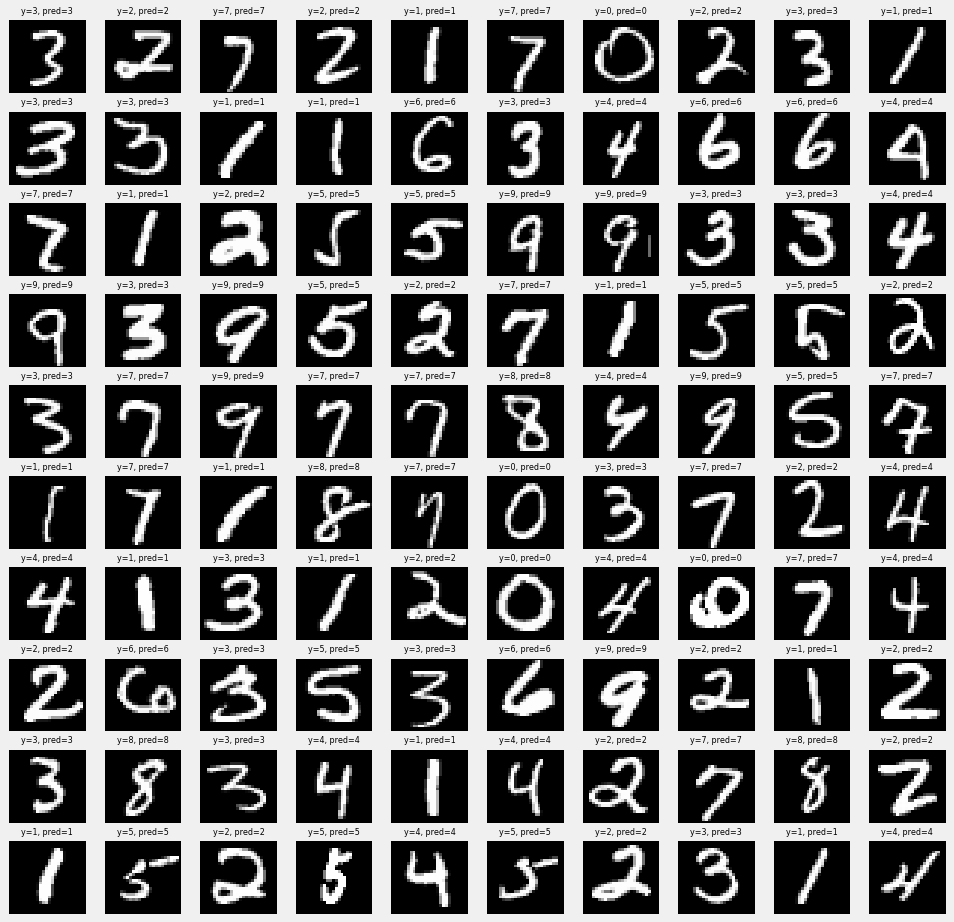

In [16]:
def draw_result(X, y, pred, cnt):
    size = 28
    Z = X.reshape(size, size)
    Z = Z[::-1,:]
    
    plt.subplot(10, 10, cnt)
    plt.xlim(0, size - 1)
    plt.ylim(0, size - 1)
    plt.pcolor(Z)
    plt.title("y={0}, pred={1}".format(y, pred), size=8)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

plt.figure(figsize=(15, 15))
for cnt, idx in enumerate(np.random.permutation(test_size)[:100]):
    x = X_test[idx]
    pred = predicate(x)
    draw_result(X_test[idx], y_test[idx], pred, cnt+1)
plt.show()

1つ目の隠れ層の重みを描画してみる

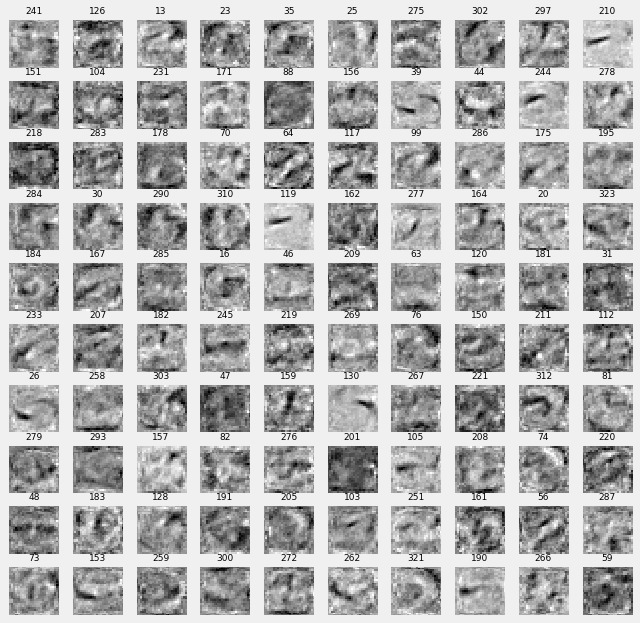

In [17]:
def draw_l1(data, cnt, idx):
    size = 28
    Z = data.reshape(size, size)
    Z = Z[::-1,:]
    
    plt.subplot(10, 10, cnt)
    plt.xlim(0, size - 1)
    plt.ylim(0, size - 1)
    plt.pcolor(Z)
    plt.title("{0}".format(idx), size=9)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

plt.figure(figsize=(10, 10))
for cnt, idx in enumerate(np.random.permutation(hidden_size)[:100]):
    draw_l1(l1_weight[-1][idx], cnt+1, idx)
plt.show()

2つ目の隠れ層の重みを描画してみる

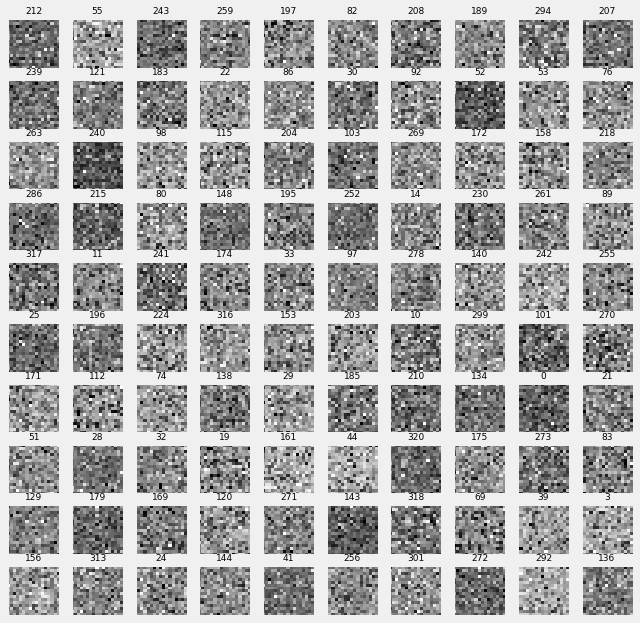

In [18]:
def draw_l2(data, cnt, idx):
    size = 18
    Z = data.reshape(size, size)
    Z = Z[::-1,:]
    
    plt.subplot(10, 10, cnt)
    plt.xlim(0, size - 1)
    plt.ylim(0, size - 1)
    plt.pcolor(Z)
    plt.title("{0}".format(idx), size=9)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

plt.figure(figsize=(10, 10))
for cnt, idx in enumerate(np.random.permutation(hidden_size)[:100]):
    draw_l2(l2_weight[-1][idx], cnt+1, idx)
plt.show()

出力層の重みを描画してみる

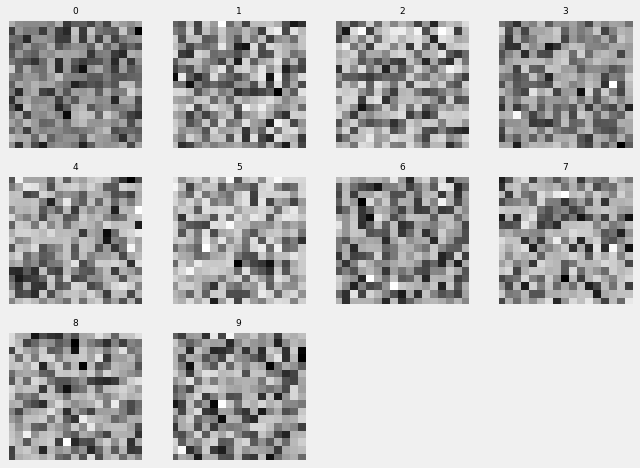

In [19]:
def draw_output(data, i):
    size = 18
    Z = data.reshape(size, size)
    Z = Z[::-1,:]
    plt.subplot(4, 4, i+1)
    
    plt.xlim(0, size - 1)
    plt.ylim(0, size - 1)
    plt.pcolor(Z)
    plt.title("{0}".format(i), size=9)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

plt.figure(figsize=(10, 10))
for i in range(output_size):
    draw_output(l3_weight[-1][i], i)
plt.show()

## 作成したモデルを保存

In [20]:
pickle.dump(model, open('data/deep_learning.dump', 'wb'), -1)